# importing libraries

In [1]:
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import string
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score,roc_curve ,precision_score,recall_score,f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import TweetTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Collection of data

# Data Collection from S3

In [ ]:
import boto3
import os

# get your credentials from environment variables
aws_id = os.environ['AWS_ID']
aws_secret = os.environ['AWS_SECRET']

client = boto3.client('s3', aws_access_key_id=aws_id,
        aws_secret_access_key=aws_secret)

bucket_name = 'my_bucket'

object_key = 'train.csv'
csv_obj = client.get_object(Bucket=bucket_name, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

data= pd.read_csv(StringIO(csv_string),header=None, encoding='ISO-8859-1')

# Data Collection from Local

In [3]:
data = pd.read_csv("/content/drive/MyDrive/train.csv" , header=None, encoding='ISO-8859-1')
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
col_names=["target", "id", "date", "flag", "user", "text"]
data.columns = col_names
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
data.shape

(1600000, 6)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


# EDA & Preprocessing

In [7]:
data["target"].value_counts()

4    800000
0    800000
Name: target, dtype: int64

Now we have large amount of rows.So lets consider 25000 rows with label 4 and 25000 with label 0

In [8]:
data=pd.concat([data.head(25000),data.tail(25000)],axis=0)
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
data["target"].value_counts()

4    25000
0    25000
Name: target, dtype: int64

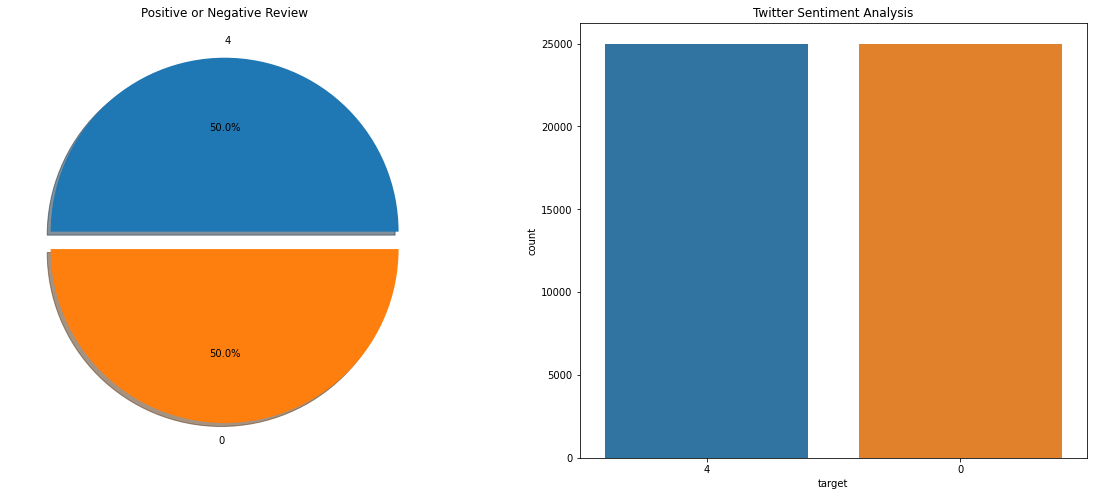

In [10]:
f,ax=plt.subplots(1,2,figsize=(20,8))
data['target'].value_counts().plot.pie(explode=[0.05,0.05],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Positive or Negative Review')
ax[0].set_ylabel('')
sns.countplot('target',order = data['target'].value_counts().index, data=data,ax=ax[1])
ax[1].set_title('Twitter Sentiment Analysis')
plt.show()

It is balanced dataset. Both Fake and Real classes have nearly equal number of instances

Negative sentiment

In [11]:
wordcloud=WordCloud(background_color="black",width=1600, height=800, random_state=0, collocations=False, stopwords=STOPWORDS).generate(' '.join(data.head(25000)['text'].tolist()))

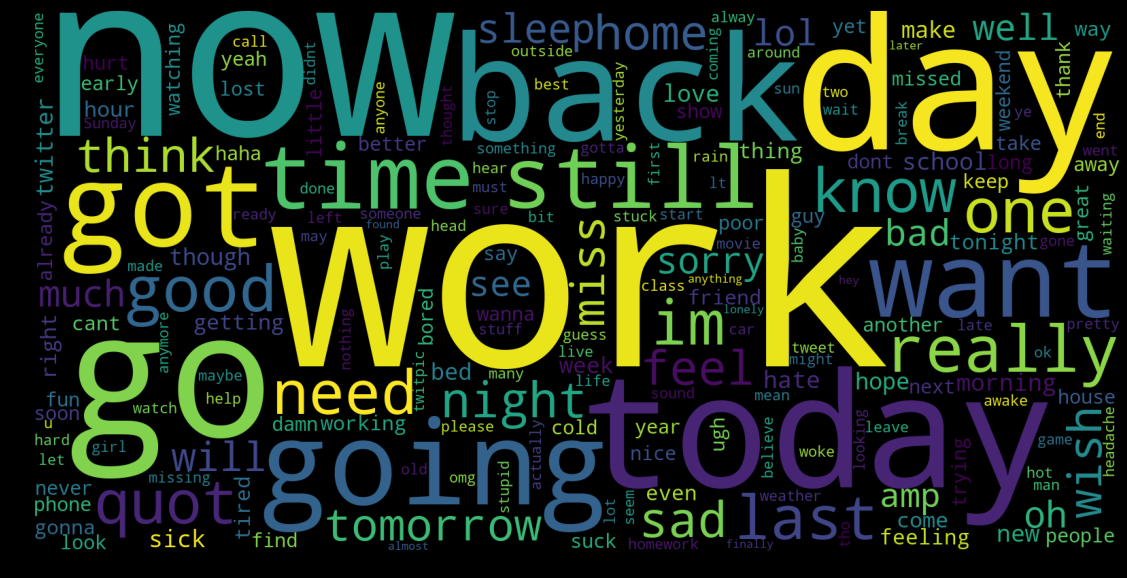

In [12]:
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

Positive sentiment

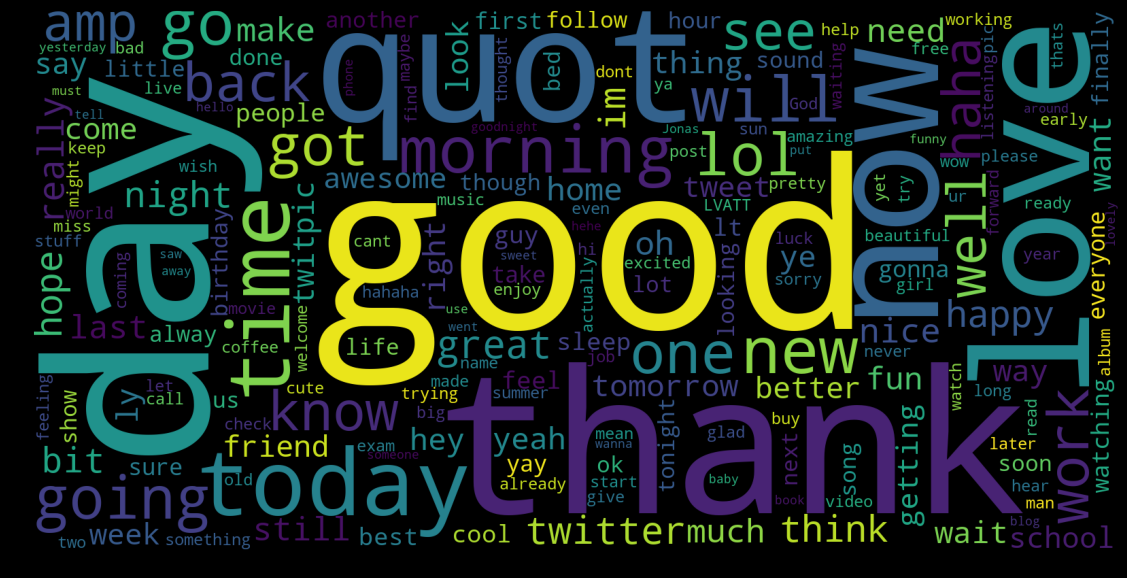

In [13]:
wordcloud=WordCloud(background_color="black",width=1600, height=800, random_state=0, collocations=False, stopwords=STOPWORDS).generate(' '.join(data.tail(25000)['text'].tolist()))

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

We convert the different articles to a matrix of token counts

Tokenizing data

We convert the different articles to a matrix of token counts

In [14]:
count_vect = CountVectorizer()
base_train = count_vect.fit_transform(data["text"])
print(base_train.shape)

(50000, 56839)


# Normalized TF/TF-IDF Representation

Now we transform the matrix of token counts to a normalized tf or tf-idf representation, where tf represents term frequency and tf-idf represents the frequency times the inverse document frequency, that way the importance/scale of certain repeated tokens throughout the text is reduced.

In [15]:
tfidf_transformer = TfidfTransformer()
base_train = tfidf_transformer.fit_transform(base_train)
print(base_train.shape)

(50000, 56839)


# Component PCA on TF-IDF Representation
Now we will reduce dimensionality on the TF-IDF Representation to 2 components to see how they differ.

In [16]:
pcaed = TruncatedSVD(n_components=2).fit_transform(base_train)
pcaed = pd.concat([pd.DataFrame(pcaed).reset_index(drop=True), data["target"].reset_index(drop=True)], axis=1)
pcaed.head()

,0,1,target
0,0.145981,-0.057429,0
1,0.148949,-0.038239,0
2,0.142067,0.042986,0
3,0.112290,-0.016898,0
4,0.183662,-0.117259,0


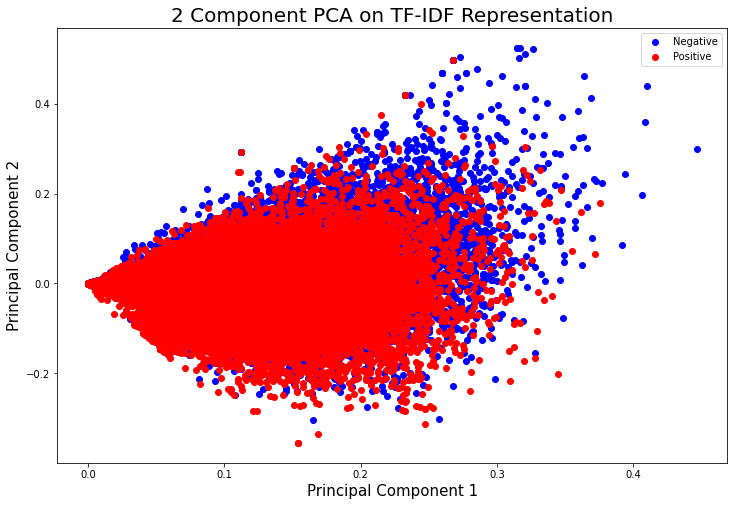

In [17]:
pctrue=pcaed[pcaed["target"]==0]
pcfake=pcaed[pcaed["target"]==4]
plt.figure(figsize = (12,8))
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 Component PCA on TF-IDF Representation', fontsize = 20)
plt.scatter(pctrue[0], pctrue[1], color="blue")
plt.scatter(pcfake[0], pcfake[1], color="red")
plt.legend(["Negative", "Positive"])

We can see that they are very similar and that there is no clear distinction between the two.

In [18]:
data.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [19]:
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Lets take text, target columns

In [20]:
data = data[["text" , "target"]]
data.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


Lets remove punctions form text in the data

In [21]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

data['text'] = data['text'].apply(lambda x: remove_punctuations(x))


Lets remove the stopwords using NLTK

In [22]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

def remove_stop_words(text):
    tokens = []
    tokenizer=TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet=tokenizer.tokenize(text)
    tweet=[word for word in tweet]
    for text in tweet:
        if text.lower() not in stop_words:
            tokens.append(text)
    tweet = " ".join(tokens)
    return tweet    

data['text'] = data['text'].apply(lambda x: remove_stop_words(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Now lets convert text to lowercase

In [23]:
def text_to_lower(text):
    return text.lower()

data['text'] = data['text'].apply(lambda x: text_to_lower(x))

data.head()

,text,target
0,switchfoot httptwitpiccom 2y1zl awww thats bum...,0
1,upset cant update facebook texting might cry r...,0
2,kenichan dived many times ball managed save 50...,0
3,whole body feels itchy like fire,0
4,nationwideclass behaving im mad cant see,0


Lets convert verbs to base form using Stemming

In [24]:
ps =PorterStemmer()

def convert_to_baseform_using_stemming(text): 
    tokens = []
    tokenizer=TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet=tokenizer.tokenize(text)
    tweet=[word for word in tweet]
    for word in tweet:
         tokens.append(ps.stem(text))
    return " ".join(tokens)        

data['text'] = data['text'].apply(lambda x: convert_to_baseform_using_stemming(x))
data.head()

,text,target
0,switchfoot httptwitpiccom 2y1zl awww thats bum...,0
1,upset cant update facebook texting might cry r...,0
2,kenichan dived many times ball managed save 50...,0
3,whole body feels itchy like fir whole body fee...,0
4,nationwideclass behaving im mad cant se nation...,0



Now lets convert noun words plural to singular using TextBlob

Now lets convert class labels into 0 for 0 and 1 for 4

In [25]:
data['target'] = data['target'].apply( lambda x: 0 if x == 0 else 1)

In [26]:
data['target'].value_counts()

1    25000
0    25000
Name: target, dtype: int64

Lets generate corpus for text processing

In [27]:
corpus = []
def create_corpus(text):
    corpus.append(text)
data['text'].apply(lambda x: create_corpus(x) )
print("length of corpus is : " , len(corpus))

length of corpus is :  50000


In [28]:
corpus_df=pd.DataFrame(corpus,columns=['Corpus'])
corpus_df[:10]

,Corpus
0,switchfoot httptwitpiccom 2y1zl awww thats bum...
1,upset cant update facebook texting might cry r...
2,kenichan dived many times ball managed save 50...
3,whole body feels itchy like fir whole body fee...
4,nationwideclass behaving im mad cant se nation...
5,kwesidei whole crew kwesidei whole crew kwesid...
6,need hug need hug
7,loltrish hey long time see yes rains bit bit l...
8,tatianak nope didnt tatianak nope didnt tatian...
9,twittera que muera twittera que muera twittera...


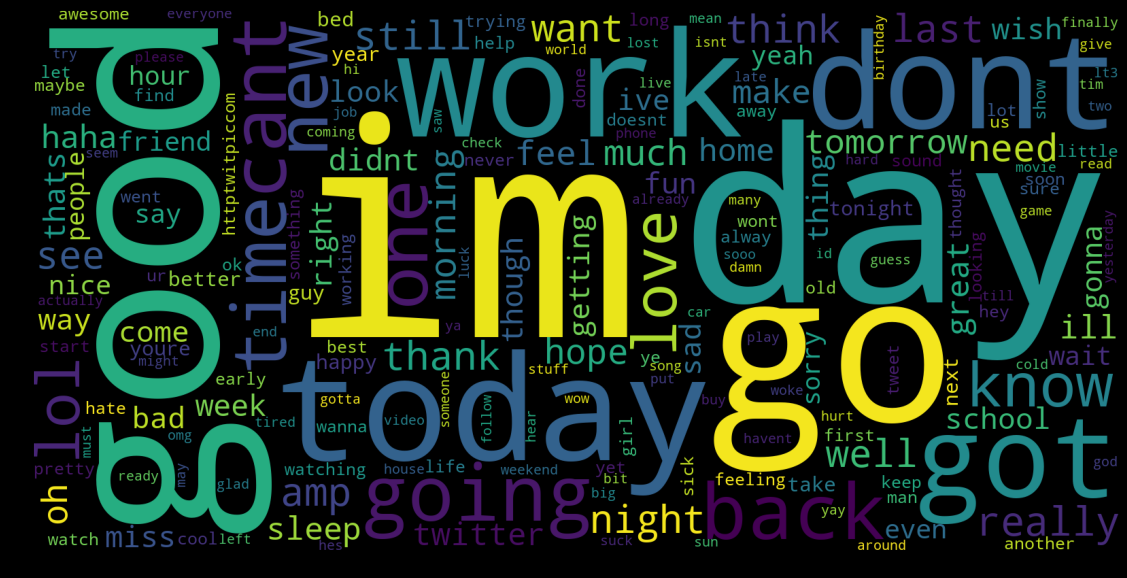

In [29]:
wordcloud=WordCloud(background_color="black",width=1600, height=800, random_state=0, collocations=False, stopwords=STOPWORDS).generate(' '.join(corpus_df['Corpus'].tolist()))

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

Now lets create bag of words model to generate features from given corpora with unigram ,bigram etc

# Creating the Bag of Words model

In [30]:
def create_bow(corpus , ngram_range ,model,accuracy , recall , precision):
    cv = CountVectorizer(max_features = 1500 ,ngram_range = ngram_range)
    X = cv.fit_transform(corpus).toarray()
    y = data['target']
    X_train, X_test, y_train, y_test = train_test_split( X,y , test_size=0.3, random_state=1)
    acc , rec , prec = model_build(X_train, y_train,X_test,y_test, model)
    accuracy.append(acc)
    recall.append(rec)
    precision.append(prec)

# Creating TF-IDF

In [31]:
def create_TF_IDF(corpus , ngram_range , model ,accuracy , recall , precision):
    tf_idf_vec = TfidfVectorizer(max_features = 1500 ,use_idf=True, 
                        smooth_idf=False,  
                        ngram_range=ngram_range) # to use only  bigrams ngram_range=(2,2)
    #transform
    X = tf_idf_vec.fit_transform(corpus).toarray()
    y = data['target']
    X_train, X_test, y_train, y_test = train_test_split( X,y , test_size=0.3, random_state=1)
    acc , rec , prec = model_build(X_train, y_train,X_test,y_test, model)
    accuracy.append(acc)
    recall.append(rec)
    precision.append(prec)

# Model_Building

In [32]:
def model_build(X, y,X_test,y_test, model):
    
    model.fit(X,y)
    #Prediction
    y_pred = model.predict(X_test)  
    accuracy = accuracy_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    print('Confusion matrix:  \n', confusion_matrix(y_test,y_pred))
    print('accuracy_score   :   ', accuracy_score(y_test,y_pred))
    print('Precision Score/FPR:' , precision_score(y_test,y_pred))
    print('Recall Score/Sensitivity/TPR:' , recall_score(y_test,y_pred))
    print('F1 Score:' , f1_score(y_test,y_pred))
    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    return accuracy , recall , precision

# Logistic Regression

Logistic Regression With BOW unigram
Confusion matrix:  
 [[5156 2489]
 [1695 5660]]
accuracy_score   :    0.7210666666666666
Precision Score/FPR: 0.694563750153393
Recall Score/Sensitivity/TPR: 0.769544527532291
F1 Score: 0.7301341589267285


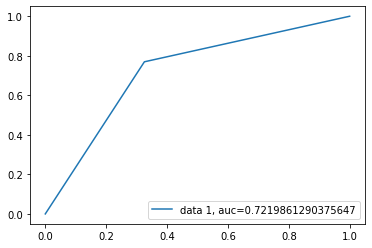

Logistic Regression With BOW bigram
Confusion matrix:  
 [[5128 2517]
 [1652 5703]]
accuracy_score   :    0.7220666666666666
Precision Score/FPR: 0.6937956204379562
Recall Score/Sensitivity/TPR: 0.7753908905506458
F1 Score: 0.7323274478330657


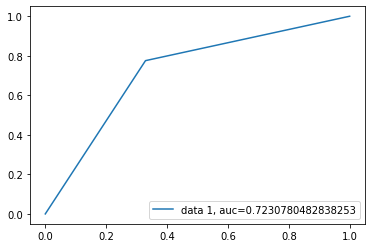

Logistic Regression With BOW triigram
Confusion matrix:  
 [[5126 2519]
 [1646 5709]]
accuracy_score   :    0.7223333333333334
Precision Score/FPR: 0.6938502673796791
Recall Score/Sensitivity/TPR: 0.7762066621346023
F1 Score: 0.7327215555412949


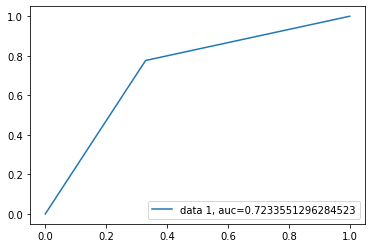

Logistic Regression With TF-IDF unigram
Confusion matrix:  
 [[5486 2159]
 [1749 5606]]
accuracy_score   :    0.7394666666666667
Precision Score/FPR: 0.7219575016097876
Recall Score/Sensitivity/TPR: 0.7622025832766826
F1 Score: 0.7415343915343917


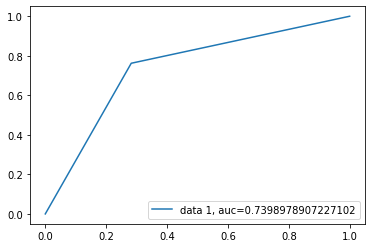

Logistic Regression With TF-IDF bigram
Confusion matrix:  
 [[5437 2208]
 [1722 5633]]
accuracy_score   :    0.738
Precision Score/FPR: 0.7184032648896824
Recall Score/Sensitivity/TPR: 0.7658735554044868
F1 Score: 0.7413793103448276


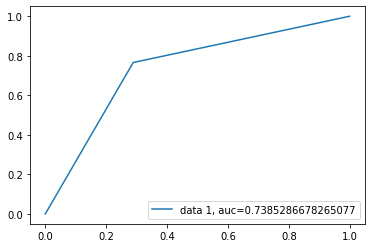

Logistic Regression With TF-IDF trigram
Confusion matrix:  
 [[5440 2205]
 [1719 5636]]
accuracy_score   :    0.7384
Precision Score/FPR: 0.7187858691493432
Recall Score/Sensitivity/TPR: 0.766281441196465
F1 Score: 0.7417741510923928


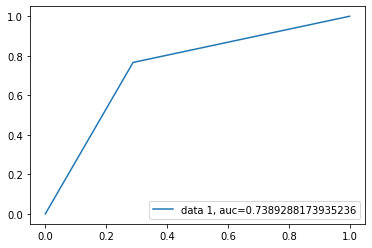

Mean Value of Accuracy of Logistic Regression  : 0.7302222222222222
Mean Value of REcall of Logistic Regression  : 0.7692499433491956
Mean Value of Precision of Logistic Regression  : 0.7068927122699735


In [33]:
lr_accuracy , lr_recall , lr_precision = [], [], []

lr = LogisticRegression()

print("Logistic Regression With BOW unigram")
create_bow(corpus , (1,1) , lr ,lr_accuracy , lr_recall , lr_precision)
print("Logistic Regression With BOW bigram")
create_bow(corpus , (1,2) , lr, lr_accuracy , lr_recall , lr_precision)
print("Logistic Regression With BOW triigram")
create_bow(corpus , (1,3) , lr , lr_accuracy , lr_recall , lr_precision)
print("Logistic Regression With TF-IDF unigram")
create_TF_IDF(corpus , (1,1) , lr, lr_accuracy , lr_recall , lr_precision)
print("Logistic Regression With TF-IDF bigram")
create_TF_IDF(corpus , (1,2) , lr ,lr_accuracy , lr_recall , lr_precision)
print("Logistic Regression With TF-IDF trigram")
create_TF_IDF(corpus , (1,3) , lr ,lr_accuracy , lr_recall , lr_precision)

print("Mean Value of Accuracy of Logistic Regression  : {}".format(np.mean(lr_accuracy)))
print("Mean Value of REcall of Logistic Regression  : {}".format(np.mean(lr_recall)))
print("Mean Value of Precision of Logistic Regression  : {}".format(np.mean(lr_precision)))

# Naive Bayes algorithm

Bernouli NaiveBayes With BOW unigram
Confusion matrix:  
 [[5435 2210]
 [1770 5585]]
accuracy_score   :    0.7346666666666667
Precision Score/FPR: 0.7164849262347659
Recall Score/Sensitivity/TPR: 0.7593473827328348
F1 Score: 0.7372937293729372


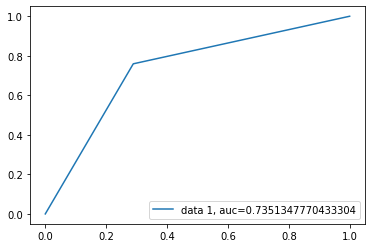

Bernouli NaiveBayes With BOW bigram
Confusion matrix:  
 [[5329 2316]
 [1666 5689]]
accuracy_score   :    0.7345333333333334
Precision Score/FPR: 0.710680824484697
Recall Score/Sensitivity/TPR: 0.773487423521414
F1 Score: 0.7407552083333332


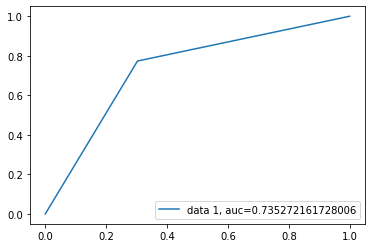

Bernouli NaiveBayes With BOW triigram
Confusion matrix:  
 [[5319 2326]
 [1645 5710]]
accuracy_score   :    0.7352666666666666
Precision Score/FPR: 0.7105525136884022
Recall Score/Sensitivity/TPR: 0.7763426240652618
F1 Score: 0.7419920732895848


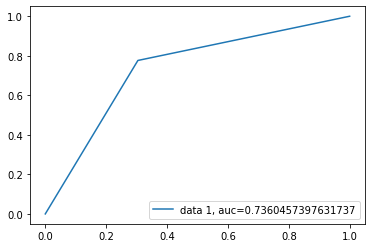

Bernouli NaiveBayes With TF-IDF unigram
Confusion matrix:  
 [[5435 2210]
 [1770 5585]]
accuracy_score   :    0.7346666666666667
Precision Score/FPR: 0.7164849262347659
Recall Score/Sensitivity/TPR: 0.7593473827328348
F1 Score: 0.7372937293729372


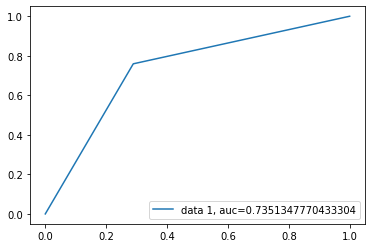

Bernouli NaiveBayes With TF-IDF bigram
Confusion matrix:  
 [[5329 2316]
 [1666 5689]]
accuracy_score   :    0.7345333333333334
Precision Score/FPR: 0.710680824484697
Recall Score/Sensitivity/TPR: 0.773487423521414
F1 Score: 0.7407552083333332


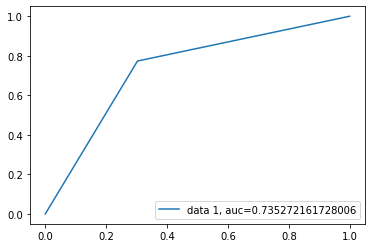

Bernouli NaiveBayes With TF-IDF trigram
Confusion matrix:  
 [[5319 2326]
 [1645 5710]]
accuracy_score   :    0.7352666666666666
Precision Score/FPR: 0.7105525136884022
Recall Score/Sensitivity/TPR: 0.7763426240652618
F1 Score: 0.7419920732895848


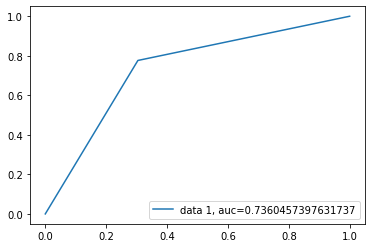

Mean Value of Accuracy of Bernouli NaiveBayes  : 0.7348222222222223
Mean Value of REcall of Bernouli NaiveBayes : 0.7697258101065035
Mean Value of Precision of Bernouli NaiveBayes  : 0.7125727548026218


In [34]:

lr_accuracy , lr_recall , lr_precision = [], [], []

lr = BernoulliNB()

print("Bernouli NaiveBayes With BOW unigram")
create_bow(corpus , (1,1) , lr ,lr_accuracy , lr_recall , lr_precision)
print("Bernouli NaiveBayes With BOW bigram")
create_bow(corpus , (1,2) , lr, lr_accuracy , lr_recall , lr_precision)
print("Bernouli NaiveBayes With BOW triigram")
create_bow(corpus , (1,3) , lr , lr_accuracy , lr_recall , lr_precision)
print("Bernouli NaiveBayes With TF-IDF unigram")
create_TF_IDF(corpus , (1,1) , lr, lr_accuracy , lr_recall , lr_precision)
print("Bernouli NaiveBayes With TF-IDF bigram")
create_TF_IDF(corpus , (1,2) , lr ,lr_accuracy , lr_recall , lr_precision)
print("Bernouli NaiveBayes With TF-IDF trigram")
create_TF_IDF(corpus , (1,3) , lr ,lr_accuracy , lr_recall , lr_precision)

print("Mean Value of Accuracy of Bernouli NaiveBayes  : {}".format(np.mean(lr_accuracy)))
print("Mean Value of REcall of Bernouli NaiveBayes : {}".format(np.mean(lr_recall)))
print("Mean Value of Precision of Bernouli NaiveBayes  : {}".format(np.mean(lr_precision)))

Gaussian NaiveBayes With BOW unigram
Confusion matrix:  
 [[3818 3827]
 [1552 5803]]
accuracy_score   :    0.6414
Precision Score/FPR: 0.6025960539979232
Recall Score/Sensitivity/TPR: 0.7889870836165873
F1 Score: 0.6833088018840152


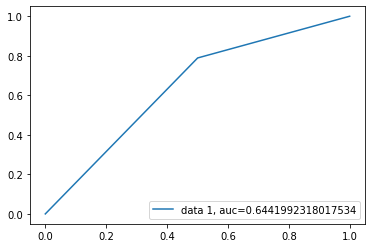

Gaussian NaiveBayes With BOW bigram
Confusion matrix:  
 [[3397 4248]
 [1201 6154]]
accuracy_score   :    0.6367333333333334
Precision Score/FPR: 0.5916169967313978
Recall Score/Sensitivity/TPR: 0.8367097212780421
F1 Score: 0.6931351016500535


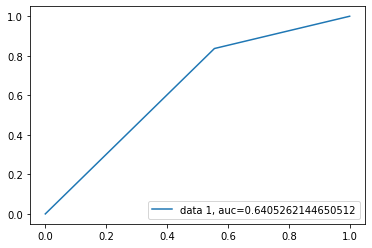

Gaussian NaiveBayes With BOW triigram
Confusion matrix:  
 [[3232 4413]
 [1136 6219]]
accuracy_score   :    0.6300666666666667
Precision Score/FPR: 0.5849322799097065
Recall Score/Sensitivity/TPR: 0.8455472467709041
F1 Score: 0.6914994162450657


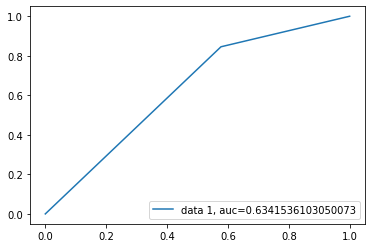

Gaussian NaiveBayes With TF-IDF unigram
Confusion matrix:  
 [[5197 2448]
 [2069 5286]]
accuracy_score   :    0.6988666666666666
Precision Score/FPR: 0.6834755624515128
Recall Score/Sensitivity/TPR: 0.7186947654656696
F1 Score: 0.7006428524090397


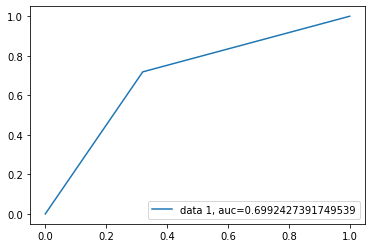

Bernouli NaiveBayes With TF-IDF bigram
Confusion matrix:  
 [[4873 2772]
 [1687 5668]]
accuracy_score   :    0.7027333333333333
Precision Score/FPR: 0.671563981042654
Recall Score/Sensitivity/TPR: 0.7706322229775663
F1 Score: 0.7176954732510289


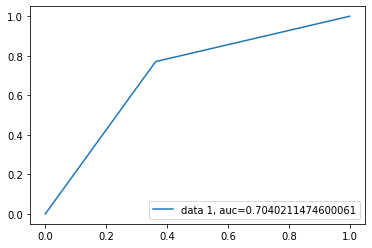

Bernouli NaiveBayes With TF-IDF trigram
Confusion matrix:  
 [[4726 2919]
 [1582 5773]]
accuracy_score   :    0.6999333333333333
Precision Score/FPR: 0.6641739530602854
Recall Score/Sensitivity/TPR: 0.7849082256968049
F1 Score: 0.7195114351592198


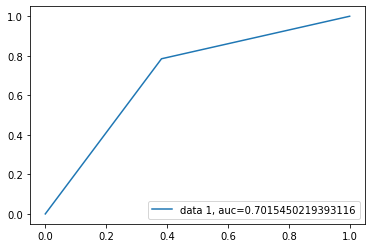

Mean Value of Accuracy of Gaussian NaiveBayes  : 0.6682888888888888
Mean Value of REcall of Gaussian NaiveBayes : 0.7909132109675957
Mean Value of Precision of Gaussian NaiveBayes  : 0.6330598045322466


In [35]:
#Naive Bayes algorithm
lr_accuracy , lr_recall , lr_precision = [], [], []

lr = GaussianNB()

print("Gaussian NaiveBayes With BOW unigram")
create_bow(corpus , (1,1) , lr ,lr_accuracy , lr_recall , lr_precision)
print("Gaussian NaiveBayes With BOW bigram")
create_bow(corpus , (1,2) , lr, lr_accuracy , lr_recall , lr_precision)
print("Gaussian NaiveBayes With BOW triigram")
create_bow(corpus , (1,3) , lr , lr_accuracy , lr_recall , lr_precision)
print("Gaussian NaiveBayes With TF-IDF unigram")
create_TF_IDF(corpus , (1,1) , lr, lr_accuracy , lr_recall , lr_precision)
print("Bernouli NaiveBayes With TF-IDF bigram")
create_TF_IDF(corpus , (1,2) , lr ,lr_accuracy , lr_recall , lr_precision)
print("Bernouli NaiveBayes With TF-IDF trigram")
create_TF_IDF(corpus , (1,3) , lr ,lr_accuracy , lr_recall , lr_precision)

print("Mean Value of Accuracy of Gaussian NaiveBayes  : {}".format(np.mean(lr_accuracy)))
print("Mean Value of REcall of Gaussian NaiveBayes : {}".format(np.mean(lr_recall)))
print("Mean Value of Precision of Gaussian NaiveBayes  : {}".format(np.mean(lr_precision)))

# PassiveAggressive Algorithm

PassiveAggressiveClassifier With BOW unigram
Confusion matrix:  
 [[5415 2230]
 [2863 4492]]
accuracy_score   :    0.6604666666666666
Precision Score/FPR: 0.6682534959833383
Recall Score/Sensitivity/TPR: 0.6107409925220938
F1 Score: 0.6382041628187823


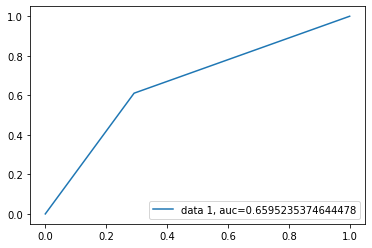

PassiveAggressiveClassifier With BOW bigram
Confusion matrix:  
 [[4622 3023]
 [2013 5342]]
accuracy_score   :    0.6642666666666667
Precision Score/FPR: 0.6386132695756127
Recall Score/Sensitivity/TPR: 0.7263086335825969
F1 Score: 0.6796437659033079


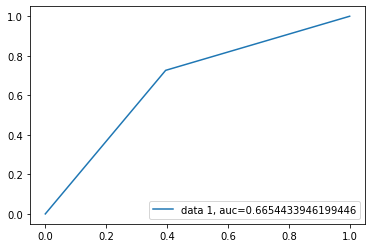

PassiveAggressiveClassifier With BOW triigram
Confusion matrix:  
 [[5665 1980]
 [3114 4241]]
accuracy_score   :    0.6604
Precision Score/FPR: 0.6817231956277126
Recall Score/Sensitivity/TPR: 0.5766145479265805
F1 Score: 0.624779021803182


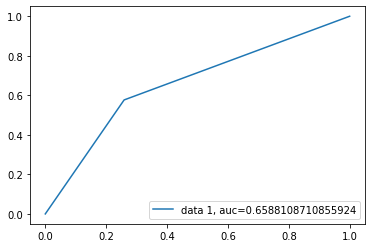

PassiveAggressiveClassifier With TF-IDF unigram
Confusion matrix:  
 [[6319 1326]
 [3254 4101]]
accuracy_score   :    0.6946666666666667
Precision Score/FPR: 0.7556661138750691
Recall Score/Sensitivity/TPR: 0.5575798776342624
F1 Score: 0.641683617587232


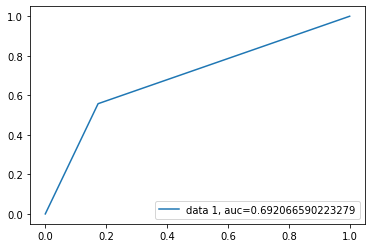

PassiveAggressiveClassifier With TF-IDF bigram
Confusion matrix:  
 [[4066 3579]
 [1042 6313]]
accuracy_score   :    0.6919333333333333
Precision Score/FPR: 0.6381924787707238
Recall Score/Sensitivity/TPR: 0.8583276682528892
F1 Score: 0.7320693453934016


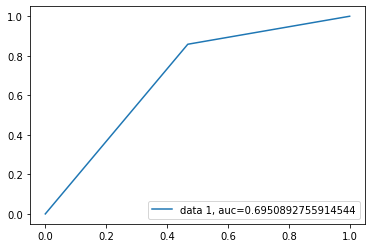

PassiveAggressiveClassifier With TF-IDF trigram
Confusion matrix:  
 [[4260 3385]
 [1113 6242]]
accuracy_score   :    0.7001333333333334
Precision Score/FPR: 0.6483847512205256
Recall Score/Sensitivity/TPR: 0.8486743711760707
F1 Score: 0.7351313155105406


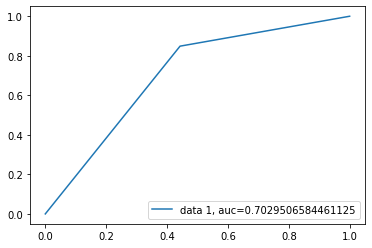

Mean Value of Accuracy of PassiveAggressiveClassifier  : 0.6786444444444445
Mean Value of REcall of PassiveAggressiveClassifier : 0.6963743485157489
Mean Value of Precision of PassiveAggressiveClassifier  : 0.6718055508421638


In [36]:


lr_accuracy , lr_recall , lr_precision = [], [], []

lr = PassiveAggressiveClassifier(max_iter=50)

print("PassiveAggressiveClassifier With BOW unigram")
create_bow(corpus , (1,1) , lr ,lr_accuracy , lr_recall , lr_precision)
print("PassiveAggressiveClassifier With BOW bigram")
create_bow(corpus , (1,2) , lr, lr_accuracy , lr_recall , lr_precision)
print("PassiveAggressiveClassifier With BOW triigram")
create_bow(corpus , (1,3) , lr , lr_accuracy , lr_recall , lr_precision)
print("PassiveAggressiveClassifier With TF-IDF unigram")
create_TF_IDF(corpus , (1,1) , lr, lr_accuracy , lr_recall , lr_precision)
print("PassiveAggressiveClassifier With TF-IDF bigram")
create_TF_IDF(corpus , (1,2) , lr ,lr_accuracy , lr_recall , lr_precision)
print("PassiveAggressiveClassifier With TF-IDF trigram")
create_TF_IDF(corpus , (1,3) , lr ,lr_accuracy , lr_recall , lr_precision)

print("Mean Value of Accuracy of PassiveAggressiveClassifier  : {}".format(np.mean(lr_accuracy)))
print("Mean Value of REcall of PassiveAggressiveClassifier : {}".format(np.mean(lr_recall)))
print("Mean Value of Precision of PassiveAggressiveClassifier  : {}".format(np.mean(lr_precision)))

# Random Forest

RandomForestClassifier With BOW triigram
Confusion matrix:  
 [[5344 2301]
 [2011 5344]]
accuracy_score   :    0.7125333333333334
Precision Score/FPR: 0.699018966644866
Recall Score/Sensitivity/TPR: 0.7265805574439157
F1 Score: 0.7125333333333334


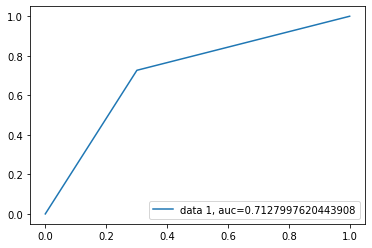

RandomForestClassifier With TF-IDF trigram
Confusion matrix:  
 [[5446 2199]
 [1989 5366]]
accuracy_score   :    0.7208
Precision Score/FPR: 0.7093192333113021
Recall Score/Sensitivity/TPR: 0.7295717199184228
F1 Score: 0.7193029490616623


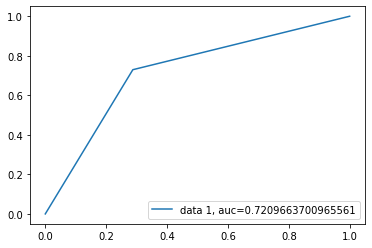

Mean Value of Accuracy of PassiveAggressiveClassifier  : 0.7166666666666667
Mean Value of REcall of PassiveAggressiveClassifier : 0.7280761386811693
Mean Value of Precision of PassiveAggressiveClassifier  : 0.7041690999780841


In [37]:
lr = RandomForestClassifier()
lr_accuracy , lr_recall , lr_precision = [], [], []




print("RandomForestClassifier With BOW triigram")
create_bow(corpus , (1,3) , lr , lr_accuracy , lr_recall , lr_precision)

print("RandomForestClassifier With TF-IDF trigram")
create_TF_IDF(corpus , (1,3) , lr ,lr_accuracy , lr_recall , lr_precision)

print("Mean Value of Accuracy of PassiveAggressiveClassifier  : {}".format(np.mean(lr_accuracy)))
print("Mean Value of REcall of PassiveAggressiveClassifier : {}".format(np.mean(lr_recall)))
print("Mean Value of Precision of PassiveAggressiveClassifier  : {}".format(np.mean(lr_precision)))

# Hyperparameter Optimization

In [38]:
tf_idf_vec = TfidfVectorizer(max_features = 1500 ,use_idf=True, 
                        smooth_idf=False,  
                        ngram_range=(1,3)) # to use only  bigrams ngram_range=(2,2)
#transform
X = tf_idf_vec.fit_transform(corpus).toarray()
y = data['target']
X_train, X_test, y_train, y_test = train_test_split( X,y , test_size=0.3, random_state=1)

In [39]:


from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 

param_grid = {

    'n_estimators': [200, 350, 400 ,500]

}

# Create a based model

rf = RandomForestClassifier()

# Instantiate the grid search model

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 

                          cv = 3, n_jobs = -1, verbose = 2)


# Fit the grid search to the data

grid_search.fit(X_train,y_train)

grid_search.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 60.1min finished


{'n_estimators': 400}

In [40]:
y_pred = grid_search.predict(X_test)  
print('Confusion matrix:  \n', confusion_matrix(y_test,y_pred))
print('accuracy_score   :   ', accuracy_score(y_test,y_pred))
print('Precision Score/FPR:' , precision_score(y_test,y_pred))
print('Recall Score/Sensitivity/TPR:' , recall_score(y_test,y_pred))
print('F1 Score:' , f1_score(y_test,y_pred))

Confusion matrix:  
 [[5443 2202]
 [1970 5385]]
accuracy_score   :    0.7218666666666667
Precision Score/FPR: 0.7097667062079873
Recall Score/Sensitivity/TPR: 0.7321549966009517
F1 Score: 0.7207870432338375
